In [1]:
%matplotlib inline

# Speech Quality Metrics Evaluation

This notebook provides visualization and comparison of speech quality metrics calculated using the `calculate-speech-metrics.py` script.

## Key Metrics Analyzed:
- **MOS (Mean Opinion Score)**: Subjective quality assessment (1-5 scale)
- **PESQ (Perceptual Evaluation of Speech Quality)**: Perceptual speech quality (-0.5 to 4.5)
- **STOI (Short-Time Objective Intelligibility)**: Speech intelligibility (0-1)
- **SDR (Signal-to-Distortion Ratio)**: Overall signal quality (dB)
- **SAR (Signal-to-Artifact Ratio)**: Artifacts in enhanced speech (dB)
- **SI-SDR (Scale-Invariant SDR)**: Scale-invariant signal quality (dB)

## Visualization Types:
- Distribution analysis of individual metrics
- Correlation heatmaps between metrics
- Multi-model performance comparison
- Radar charts for comprehensive model evaluation

In [2]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

## Setup and Imports

Import necessary libraries for data analysis, visualization, and statistical processing.

In [ ]:
CSV_PATH = './METRICS/VoiceBank+DEMAND/baseline_speech_metrics.csv'

## Configuration and Data Loading

Configure paths to the CSV files containing speech quality metrics calculated by `calculate-speech-metrics.py`.

> **Note**: Update the `CSV_PATH` variable to point to your specific metrics file. The path should match the output location specified in the `calculate-speech-metrics.py` script.

In [5]:
sns.set_theme(style="darkgrid", palette="rocket")

In [6]:
df = pd.read_csv(CSV_PATH)

## Visualization Helper Functions

Define reusable functions for creating consistent and informative visualizations of speech quality metrics.

In [ ]:
def plot_metrics_distributions(data):
    plt.figure(figsize=(16, 10))

    metrics = ['MOS', 'SDR', 'SAR', 'SI-SDR', 'STOI', 'PESQ']

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 3, i)
        sns.histplot(data[metric], kde=True, bins=10, color=sns.color_palette("rocket", as_cmap=True)(i/8))
        plt.title(f'Distribution of {metric}')
        plt.xlabel(metric)
        plt.ylabel('# of Files')

    plt.tight_layout()
    plt.savefig(CSV_PATH.replace(".csv", "_distributions.png").replace("METRICS", "plots"))
    plt.show()

def plot_normalized_boxplot(data):
    scaler = MinMaxScaler()
    normalized_metrics = scaler.fit_transform(data[['MOS', 'SDR', 'SAR', 'SI-SDR', 'STOI', 'PESQ']])
    normalized_data = pd.DataFrame(normalized_metrics, columns=['MOS', 'SDR', 'SAR', 'SI-SDR', 'STOI', 'PESQ'])

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 1, 1)
    sns.boxplot(data=normalized_data, palette='rocket')
    plt.title('Normalized Metric Distribution')
    plt.ylabel('Normalized Metric Values')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig(CSV_PATH.replace(".csv", "_boxplot.png"))
    plt.show()

# Metric Distribution Analysis

Analyze the distribution of speech quality metrics for a single model to understand performance characteristics and identify potential outliers.

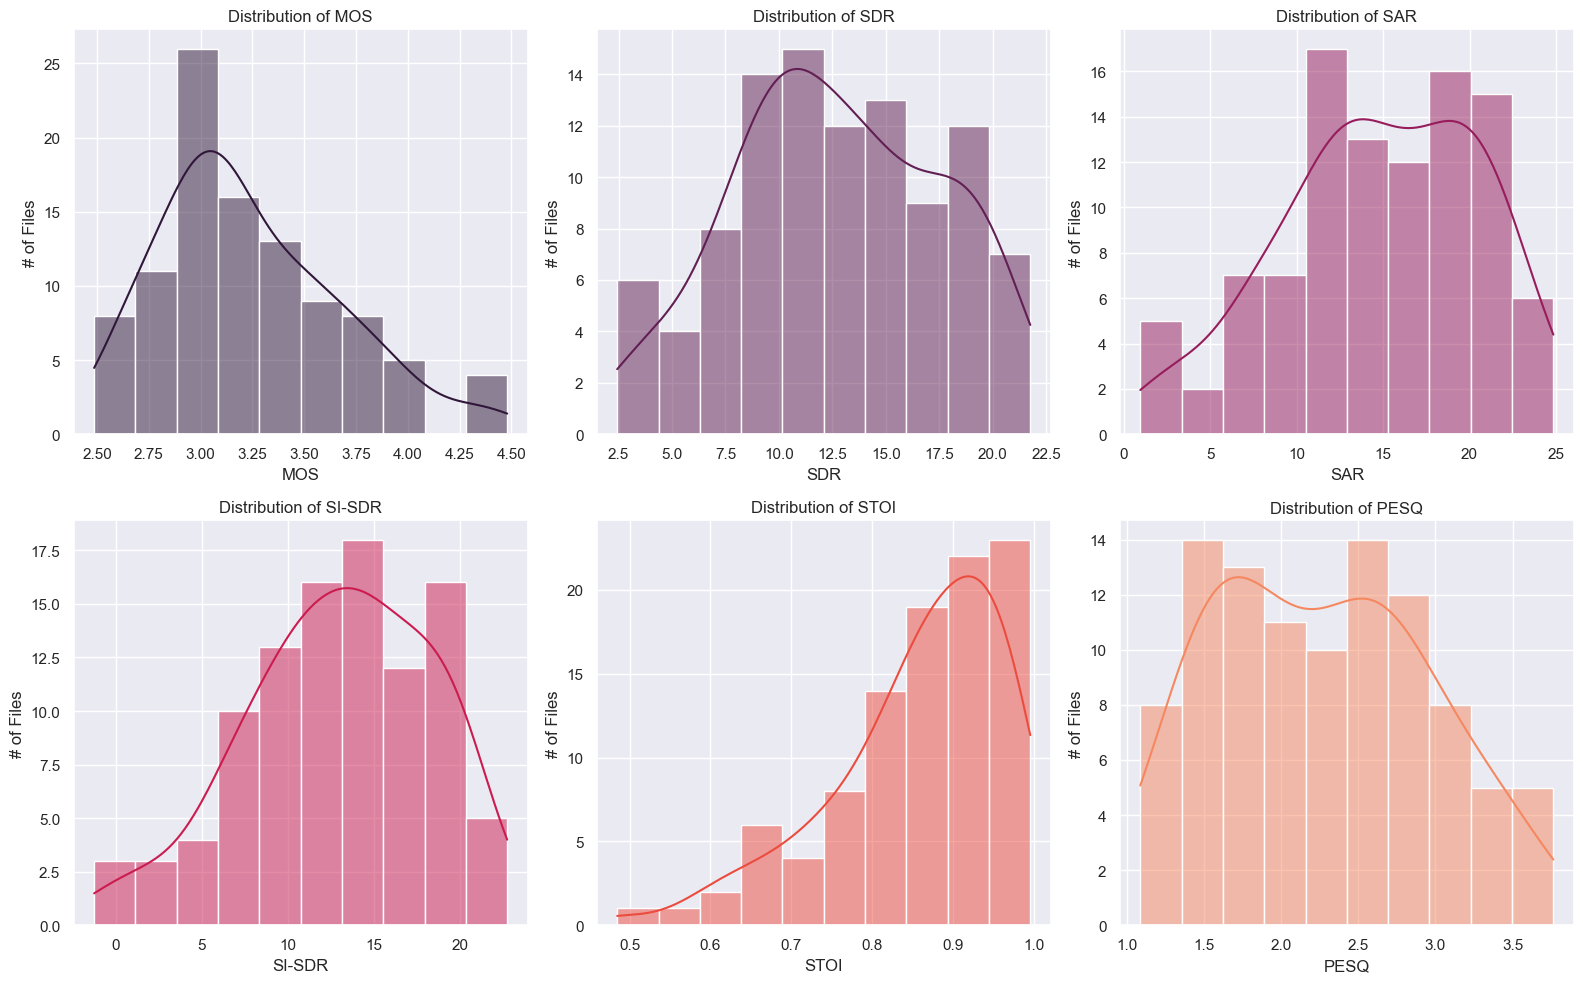

In [8]:
plot_metrics_distributions(data=df)

## Metric Correlation Analysis

Examine correlations between different speech quality metrics to understand their relationships and identify redundant or complementary measures.

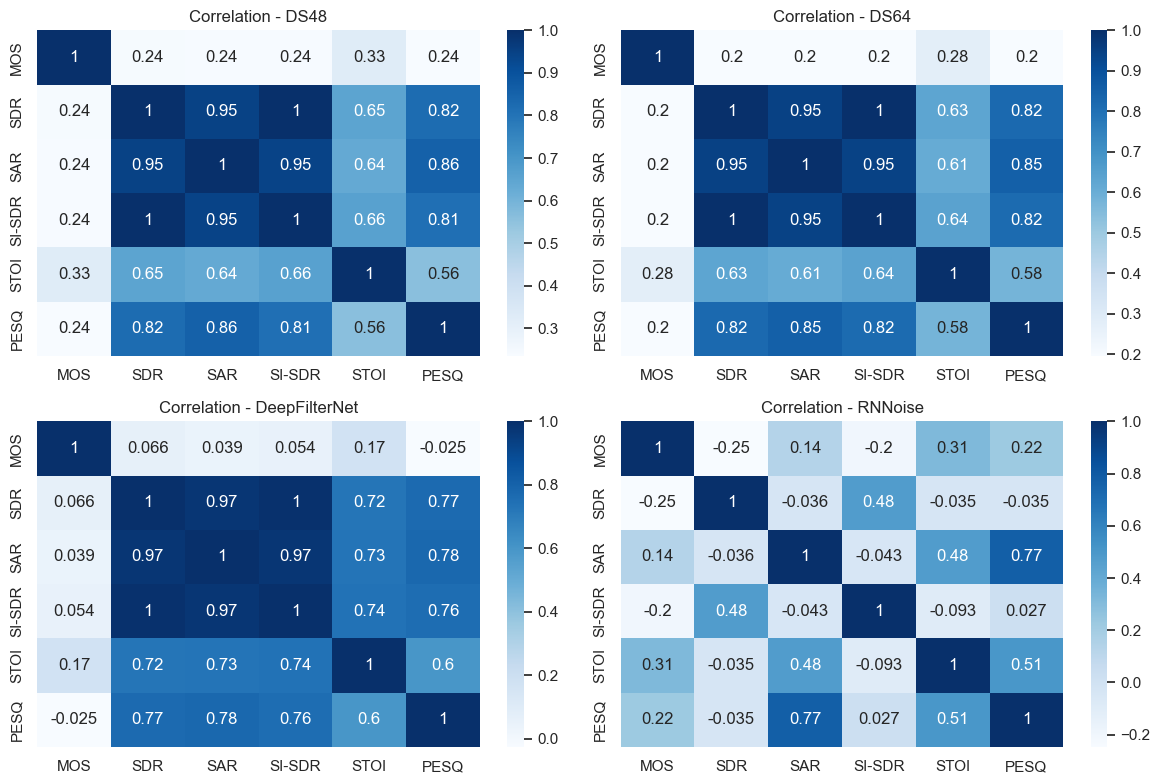

In [ ]:
directory = "./METRICS/New/"
csv_files = [f for f in os.listdir(directory) if f.endswith(".csv")]

num_files = len(csv_files)
rows, cols = (2, 2) if num_files >= 4 else (1, num_files)

fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten() if num_files > 1 else [axes]

for i, file in enumerate(csv_files[:4]): 
    df = pd.read_csv(os.path.join(directory, file))
    numeric_df = df.drop(columns=["File Name"], errors='ignore')
    
    ax = axes[i]
    sns.heatmap(numeric_df.corr(), annot=True, cmap="Blues", ax=ax)
    ax.set_title(f"Correlation - {file.replace('.csv', '')}")

plt.tight_layout()
plt.savefig('./plots/metrics_correlation_heatmaps.png')
plt.show()

# Data Aggregation

Load and combine metrics from multiple models for comprehensive comparison analysis. This section processes all CSV files in the metrics directory and prepares them for comparative visualization.

In [3]:
directory = "./METRICS/VoiceBank+DEMAND/"
csv_files = [f for f in os.listdir(directory) if f.endswith(".csv")]

all_data = []
for file in csv_files:
    df = pd.read_csv(os.path.join(directory, file))
    model_name = os.path.splitext(file)[0]
    df['Model'] = model_name

    df = df.drop(columns=["filename"], errors='ignore')
    all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)

## Combined Dataset Preview

Preview the combined dataset structure to verify data loading and understand the available models and metrics.

In [4]:
combined_df.head()

,MOS,SDR,SAR,SI-SDR,STOI,PESQ,SNR,Model
0,3.079440,11.143415,14.900448,12.970340,0.942454,2.577437,11.143415,Optimized-Model
1,3.454629,10.634814,11.124059,10.473298,0.859800,1.472574,10.634813,Optimized-Model
2,2.808597,8.523438,9.453011,8.263659,0.723284,1.493967,8.523439,Optimized-Model
3,3.090868,4.832501,4.930364,4.199441,0.659392,1.157512,4.832502,Optimized-Model
4,3.003474,14.137476,18.804706,14.484786,0.761450,2.183678,14.137475,Optimized-Model


In [ ]:
avg_metrics = combined_df.groupby('Model').mean().reset_index()

metrics = [col for col in avg_metrics.columns if col != 'Model']

## Metrics Aggregation and Normalization

Calculate average performance metrics for each model and normalize them for fair comparison across different metric scales.

**Normalization Benefits:**
- Enables comparison across metrics with different scales (e.g., MOS: 1-5, STOI: 0-1, SDR: dB)
- Highlights relative performance differences
- Facilitates radar chart visualization

In [ ]:
normalized = avg_metrics.copy()
for metric in metrics:
    min_val = combined_df[metric].min()
    max_val = combined_df[metric].max()
    normalized[metric] = (avg_metrics[metric] - min_val) / (max_val - min_val)

# **Metrics Interpretation Guide:**

| Metric | Range | Higher = Better | Focus Area |
|--------|-------|----------------|------------|
| **MOS** | 1-5 | ✅ Yes | Overall subjective quality |
| **PESQ** | -0.5 to 4.5 | ✅ Yes | Perceptual speech quality |
| **STOI** | 0-1 | ✅ Yes | Speech intelligibility |
| **SDR** | dB scale | ✅ Yes | Signal-to-distortion ratio |
| **SAR** | dB scale | ✅ Yes | Artifact suppression |
| **SI-SDR** | dB scale | ✅ Yes | Scale-invariant quality |

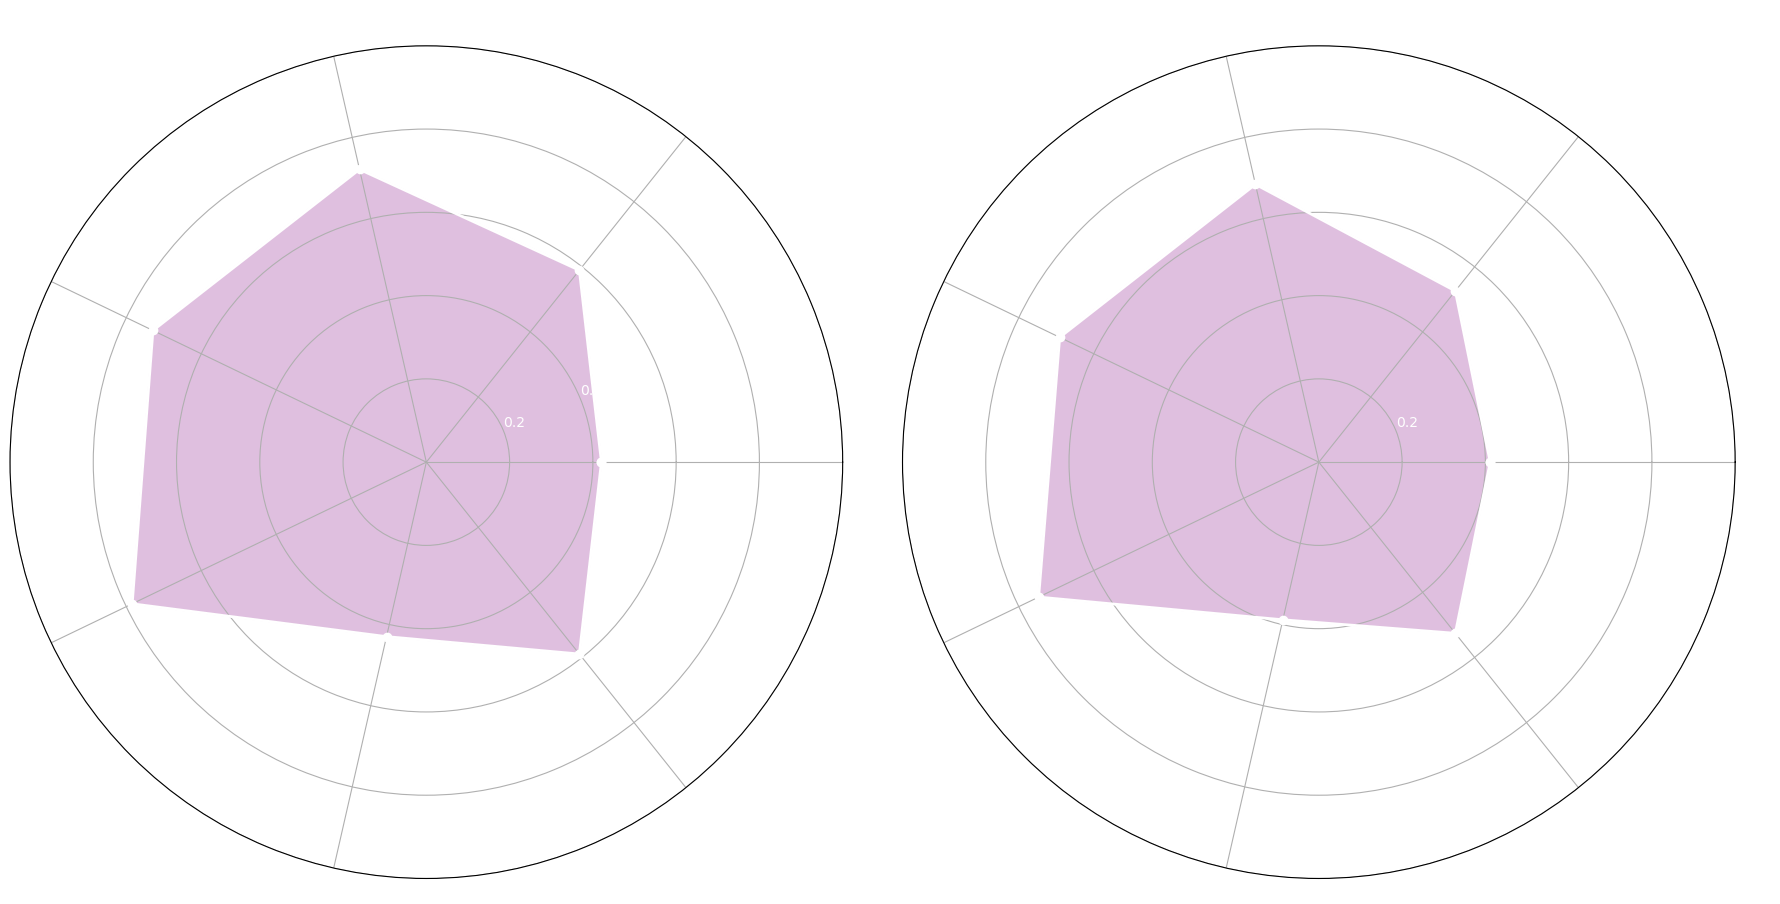

In [ ]:
normalized = normalized.set_index('Model').loc[['Baseline-Model', 'Optimized-Model']].reset_index()

num_metrics = len(metrics)
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]

num_models = normalized.shape[0]
rows = int(np.ceil(num_models / 2))
fig, axes = plt.subplots(1, 2, subplot_kw=dict(polar=True), figsize=(18, 10 * rows))
if num_models == 1:
    axes = [axes]
else:
    axes = axes.flatten()

fig.patch.set_alpha(0)

for i, (_, row) in enumerate(normalized.iterrows()):
    values = row[metrics].tolist()
    values += values[:1]
    ax = axes[i]
    ax.plot(angles, values, 'o-', linewidth=2, color='white')  
    ax.fill(angles, values, alpha=0.25, color='purple')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, color='white')  
    ax.tick_params(axis='x', colors='white')  
    ax.tick_params(axis='y', colors='white')  
    ax.set_title(row['Model'], color='white') 
    ax.set_ylim(0, 1)
    ax.patch.set_alpha(0)

plt.tight_layout()
plt.savefig('./plots/Models_metrics_radar.png', transparent=True)
plt.show()